In [9]:
pip install coinmetrics-api-client

Note: you may need to restart the kernel to use updated packages.


In [10]:
from coinmetrics.api_client import CoinMetricsClient

client = CoinMetricsClient()

print(client)

In [56]:
# 'SplyCntCur' - this is for the supply count of the current coin
# 'CapMrktCurUSD' - this is for the market capitalization of the current coin
# 'PriceUSD' - this is for the price of the current coin
# 'TxTfrValAdjUSD' - this is for the adjusted transaction value in USD
# 'TxTfrValUSD' - this is for the transaction value in USD  
# 'TxTfrCnt' - this is for the transaction count
# 'IssContNtv' - this is for the native issuance count
# 'IssContPctAnn' - this is for the annual percentage of the issuance count
# 
metrics = client.get_asset_metrics(assets='btc', metrics=['PriceUSD','HashRate','TxTfrCnt','AdrActCnt', 'SplyCur'], start_time="2013-01-01", end_time="2023-01-02", frequency='1d')

In [57]:
print(metrics)

In [62]:
import pandas as pd

metrics = pd.DataFrame(metrics)

metrics.head()

metrics.to_csv("coin_metrics.csv", index=False)

df = metrics.copy()


In [68]:

# Ensure datetime and sort
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)

# Create lag features (previous day's metrics)
df['PriceUSD_t-1'] = df['PriceUSD'].shift(1)
df['TxTfrCnt_t-1'] = df['TxTfrCnt'].shift(1)
df['AdrActCnt_t-1'] = df['AdrActCnt'].shift(1)
df['HashRate_t-1'] = df['HashRate'].shift(1)
df['SplyCur_t-1'] = df['SplyCur'].shift(1)

# Target: future price (e.g., 1-day ahead)
df['PriceUSD_target'] = df['PriceUSD'].shift(-1)

# Drop missing values from lagging
df.dropna(inplace=True)

In [69]:
from sklearn.model_selection import train_test_split

X = df[['PriceUSD_t-1', 'TxTfrCnt_t-1', 'AdrActCnt_t-1', 'HashRate_t-1', 'SplyCur_t-1']]
y = df['PriceUSD_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")

df.loc[y_test.index, 'actual_price_usd'] = y_test.values
df.loc[y_test.index, 'predicted_price_usd'] = y_pred

df_to_save = df[['time', 'actual_price_usd', 'predicted_price_usd']].dropna()

# Save to CSV
df_to_save.to_csv("btc_price_actual_vs_predicted.csv", index=False)

MAE: 13773.57


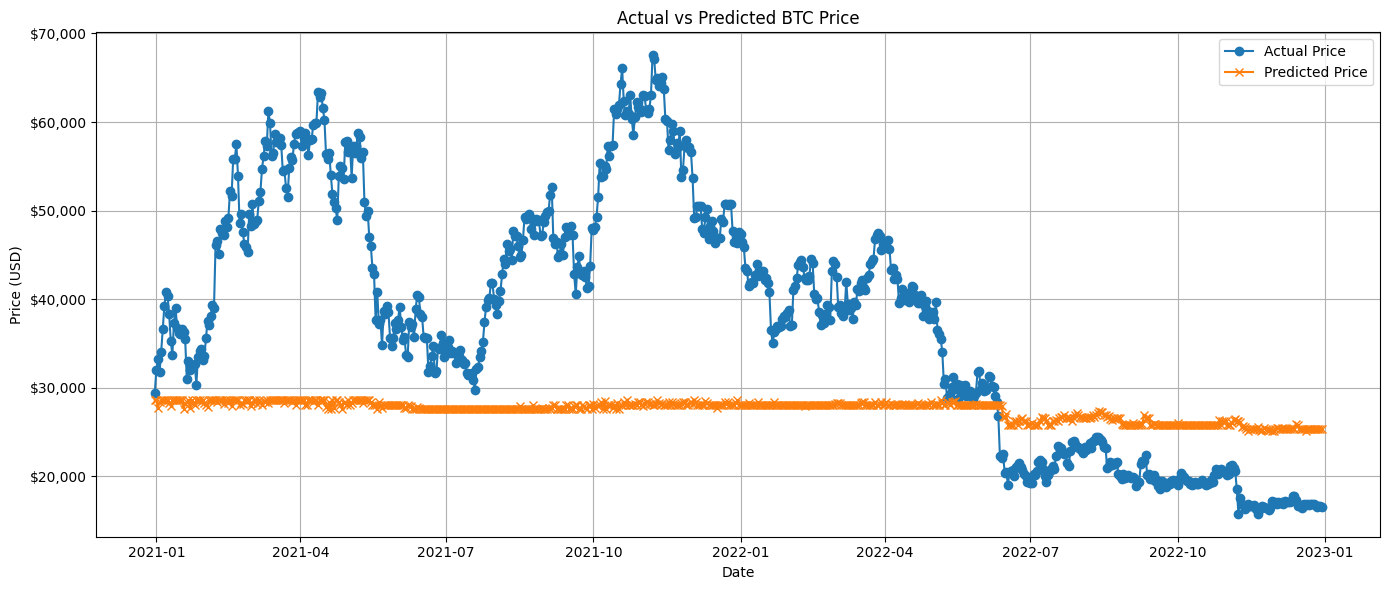

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

# Optional: reload CSV if needed
df_to_save = pd.read_csv("btc_price_actual_vs_predicted.csv")

# Ensure time is in datetime format
df_to_save['time'] = pd.to_datetime(df_to_save['time'])

# Plot
plt.figure(figsize=(14, 6))

# Plot actual prices
plt.plot(df_to_save['time'], df_to_save['actual_price_usd'], label='Actual Price', marker='o')

# Plot predicted prices
plt.plot(df_to_save['time'], df_to_save['predicted_price_usd'], label='Predicted Price', marker='x')

# Format Y-axis as currency
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Titles and labels
plt.title("Actual vs Predicted BTC Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


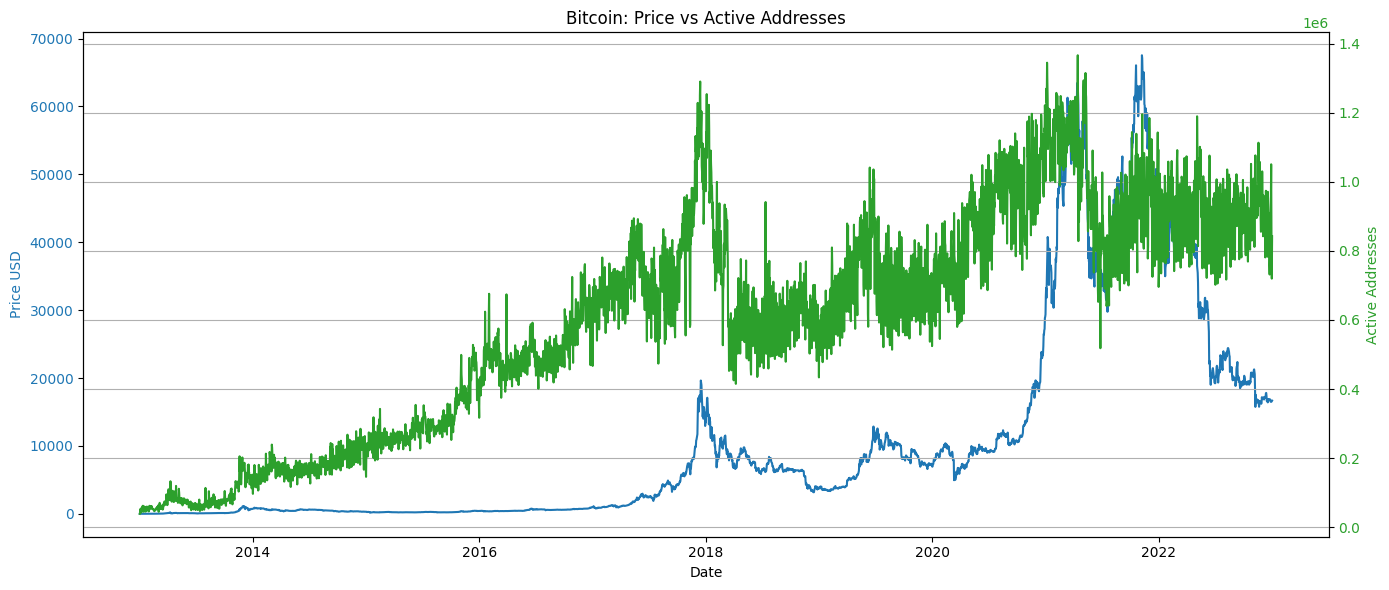

In [ ]:
import matplotlib.pyplot as plt

# Ensure columns are numeric
metrics['PriceUSD'] = pd.to_numeric(metrics['PriceUSD'], errors='coerce')
metrics['AdrActCnt'] = pd.to_numeric(metrics['AdrActCnt'], errors='coerce')

# Start the plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot PriceUSD on left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price USD', color=color)
ax1.plot(metrics['time'], metrics['PriceUSD'], color=color, label='Price USD')
ax1.tick_params(axis='y', labelcolor=color)

# Create second Y-axis
ax2 = ax1.twinx()  # Share the same x-axis

# Plot Active Addresses on right Y-axis
color = 'tab:green'
ax2.set_ylabel('Active Addresses', color=color)
ax2.plot(metrics['time'], metrics['AdrActCnt'], color=color, label='Active Addresses')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and grid
plt.title("Bitcoin: Price vs Active Addresses")
fig.tight_layout()
plt.grid(True)
plt.show()